In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip install skimpy 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount = True) 
%cd "/content/gdrive/My Drive/AAAPortfolio/kaggle_comp"   

Mounted at /content/gdrive/
/content/gdrive/My Drive/AAAPortfolio/kaggle_comp


## 1. Figure Out The Question 

We wish to predict the sale prices of houses using features having to do with square footage, neighborhood, etc. We use the Ames data set which consists of 80 features that we will use. The data is pretty mess as we will find out. 

## 2. Obtain a Labeled Data Set 

Below we read in the labeled dataset and the unlabeled set -- out train and test sets respectively. We will have to clean the data quite a bit. Some of these ideas have been inspired from other kernels online but we notice that there are some outliars and missing values that ought to be considered. There are also a number of categorical variables that we ought to deal with effectively. 

In [ ]:
train = pd.read_csv("./raw_data/train.csv")
test = pd.read_csv("./raw_data/test.csv")
print("Train size: {}".format(train.shape))
print("Test size:  {}".format(test.shape))

target = train.SalePrice # save in its own variable 

Train size: (1460, 81)
Test size:  (1459, 80)


In [ ]:
# start to describe the data 
print("Train size: {}".format(train.shape))
print("\nTarget Data: ")
print(target.describe()) 

Train size: (1460, 81)

Target Data: 
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
train.head() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
Id_train, Id_test = train.Id, test.Id # save ID's of specific houses 

### Note that the SalesPrice is pretty skewed. Lets log it to elininate the heteroskedasticity in hopes that it looks more normally distributed. That will be easier to work with. When we are done and making final predictions, we'll exponentiate it all. 

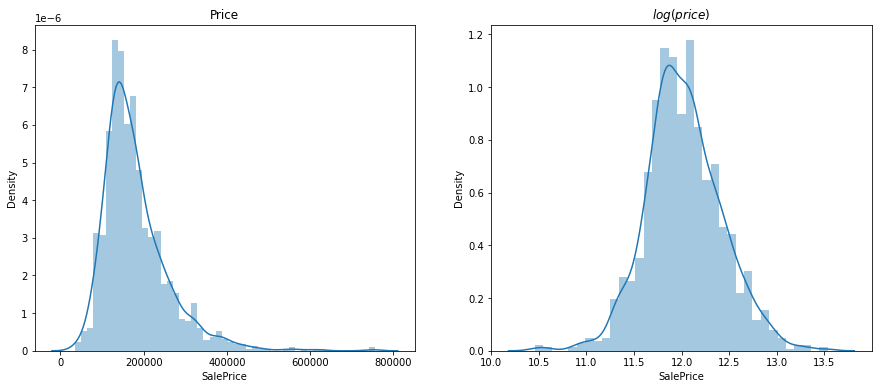

In [ ]:
log_target = np.log(target)

plt.figure(figsize = (15, 6))

plt.subplot(121)
sns.distplot(target)
plt.title("Price")

plt.subplot(122)
sns.distplot(log_target)
plt.title("$log(price)$")

plt.show()

### Look at the outliars here -- this isnt great. We'll see that this variable is STRONGLY correlated with SalesPrice so this is an important one to look at. We eliminate these variables since they will lever our lines of best fit negatively. 

In [ ]:
train = train.drop(train[(train['GrLivArea'] > 4500) & (target < 300000)].index)

In [ ]:
# missing data put into a data-frame 
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageYrBlt,81,0.055556
GarageCond,81,0.055556
GarageType,81,0.055556
GarageFinish,81,0.055556


### Here are a lot of categorical variables that need to be dealt with. We want to keep the ones that are numeric numeric, and we want to be able to convert the others into dummy variables later on. I impute some missing values here too. 

In [ ]:
train["PoolQC"], test["PoolQC"] = train["PoolQC"].fillna("None"), test["PoolQC"].fillna("None")

train["MiscFeature"], test["MiscFeature"] = train["MiscFeature"].fillna("None"), test["MiscFeature"].fillna("None")

train["Alley"], test["Alley"] = train["Alley"].fillna("None"), test["Alley"].fillna("None")

train["Fence"], test["Fence"] = train["Fence"].fillna("None"), test["Fence"].fillna("None")

train["FireplaceQu"], test["FireplaceQu"] = train["FireplaceQu"].fillna("None"), test["FireplaceQu"].fillna("None")

train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])

train = train.drop(['Utilities'], axis = 1)
test = test.drop(['Utilities'], axis = 1)

train["Functional"] = train["Functional"].fillna("Typ")
test["Functional"] = test["Functional"].fillna("Typ")

train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])

train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])

train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

train['MSSubClass'] = train['MSSubClass'].fillna("None")
test['MSSubClass'] = test['MSSubClass'].fillna("None")

In [ ]:
for col in ["BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond", "BsmtQual"]: 
    train[col] = train[col].fillna("Typ")
    test[col] = test[col].fillna("Typ")

# train 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
    
# test 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)

### Here I create a new variable -- Total Square Feet -- and then create a square of that, adding both to the train and test sets. I drop the component variables to eliminate collinearities. 

In [ ]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

train['TotalSFSQ'] = train['TotalSF'] * train['TotalSF']
test['TotalSFSQ'] = test['TotalSF'] * test['TotalSF']

train = train.drop(["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"], axis = 1)
test = test.drop(["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"], axis = 1)

### All of these Garage variables had the exact same amount of values missing as we saw in the DataFrame made earlier. This suggests something systematic in why they are missing which could skew the predictions. We thus eliminate them. 

In [ ]:
train = train.drop(["GarageCond", "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual"], axis = 1)
test = test.drop(["GarageCond", "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual"], axis = 1)

In [ ]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,TotalSFSQ
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,...,None,None,0,2,2008,WD,Normal,208500,2566,6584356
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,...,None,None,0,5,2007,WD,Normal,181500,2524,6370576
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,...,None,None,0,9,2008,WD,Normal,223500,2706,7322436
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,...,None,None,0,2,2006,WD,Abnorml,140000,2473,6115729
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,...,None,None,0,12,2008,WD,Normal,250000,3343,11175649


In [ ]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(7)

,Total,Percent
Id,0,0.0
GarageArea,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0


In [ ]:
train.shape, test.shape

((1458, 74), (1459, 73))

In [ ]:
target = train["SalePrice"]
log_target = np.log(target)
train = train.drop(["SalePrice"], axis = 1)
target.shape, train.shape, test.shape

((1458,), (1458, 73), (1459, 73))

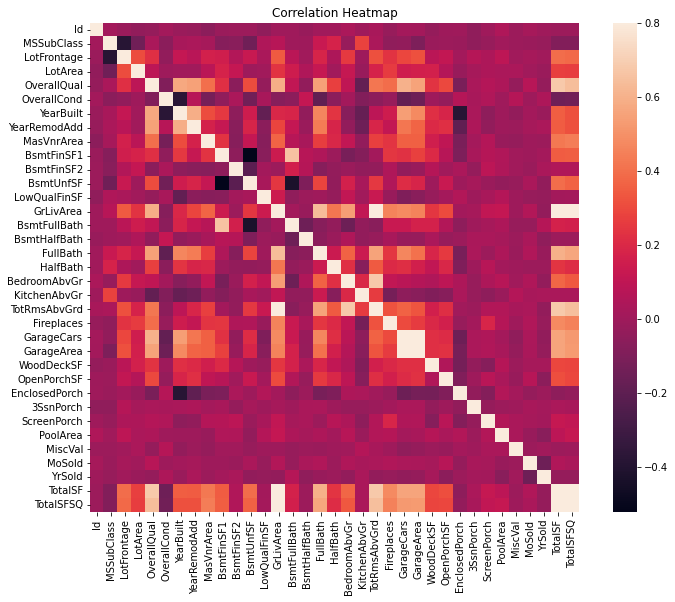

In [ ]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
Id_train, Id_test = train.Id, test.Id
train = train.drop(["Id"], axis = 1)
test = test.drop(["Id"], axis = 1)

test = pd.get_dummies(test, drop_first = True) 
train = pd.get_dummies(train, drop_first = True)
test.shape, train.shape

((1459, 221), (1458, 236))

### We dont have the same number of columns after getting_dummies. That's ok -- We find the difference between sets of the dataframes columns then eliminate the extra ones. Kind of ghetto but gets the job done. 

In [ ]:
test_col = set(test.columns) 
train_col = set(train.columns) 
diff = train_col.difference(test_col) # find the difference between the train and test columns 

diff = list(set(train.columns).difference(set(test.columns))) # make a list of the differences 
train = train.drop(train[diff], axis = 1) # get rid of the extra train columns 

### Note that all the columns from the two dataframes are the same now!

In [ ]:
print("All columns are the same: {}".format(all(train.columns == test.columns))) 

All columns are the same: True


In [ ]:
# fill any straggling missing values with the means 

In [ ]:
train, test = train.fillna(train.mean()), test.fillna(test.mean())        

In [ ]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
train["target"] = target
train["log_target"] = log_target
train["Id"] = Id_train

train.info(), train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Columns: 224 entries, MSSubClass to Id
dtypes: float64(3), int64(34), uint8(187)
memory usage: 699.1 KB


(None, (1458, 224))

In [ ]:
test["Id"] = Id_test
test.info(), test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 222 entries, MSSubClass to Id
dtypes: float64(11), int64(24), uint8(187)
memory usage: 665.5 KB


(None, (1459, 222))

In [ ]:
train.to_csv("./raw_data/train_clean.csv") 
test.to_csv("./raw_data/test_clean.csv") 